##### README
- the goal of this notebook is to create a simple chatbot with tool calling within LangGraph
- this graph is extensible for future tool integrations to chatbot

In [1]:
import dotenv
dotenv.load_dotenv(override=True)

True

In [2]:
import os
import sys

from IPython.display import Image, display

from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

if not os.environ.get("OPENAI_API_KEY"):
    print("Please set your OPENAI_API_KEY environment variable.")
    # sys.exit(1) # Uncomment to enforce exit if no key found

C:\Users\Danny\Desktop\tmp\venvs\langgraph\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [36]:
# --- 1. Define the Tool ---
# We use the @tool decorator so LangChain can convert it to an OpenAI function schema.
@tool
def get_current_weather(city: str) -> str:
    """Get the current weather for a specific city."""
    # In a real app, you would hit an API here.
    # For this toy example, we return hardcoded data.
    if "toronto" in city.lower():
        return "It is currently 15°C and cloudy in Toronto."
    elif "new york" in city.lower():
        return "It is currently 22°C and sunny in New York."
    else:
        return "Weather data not available for this location."

tools = [get_current_weather]

# --- 2. Define the State ---
class State(TypedDict):
    messages: Annotated[list, add_messages]

# --- 3. Define the Nodes ---

# Initialize LLM and bind the tool
llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)
llm_with_tools = llm.bind_tools(tools)

def chatbot_node(state: State):
    # The LLM sees the history and decides if it needs to call a tool
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 'ToolNode' is a prebuilt LangGraph node that executes the tools 
# requested in the last message of the state.
tool_node = ToolNode(tools)

# --- 4. Build the Graph ---
builder = StateGraph(State)

builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", tool_node)

builder.add_edge(START, "chatbot")

# Conditional Logic:
# Check the last message. If it has 'tool_calls', go to 'tools'.
# Otherwise, go to END.
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Crucial Step: Loop back!
# After the tool runs, we must go back to the chatbot so the LLM 
# can read the tool output and formulate a natural language response.
builder.add_edge("tools", "chatbot")

# Compile with Memory
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

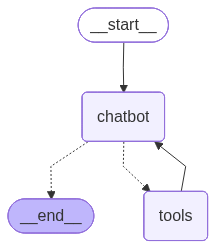

In [37]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Fallback if specific system dependencies are missing
    print(graph.get_graph().draw_mermaid())

In [38]:
# A thread_id isolates this conversation (like a session ID)
config = {"configurable": {"thread_id": "1"}}

print("--- Turn 1 ---")
user_input = "Hi, my name is Alice."
events = graph.stream(
    {"messages": [("user", user_input)]}, 
    config, 
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

--- Turn 1 ---
================================ Human Message =================================

Hi, my name is Alice.
================================== Ai Message ==================================

Hello Alice! How can I assist you today?


In [39]:
print("\n--- Turn 2 ---")
user_input_2 = "What is the weather?"
events = graph.stream(
    {"messages": [("user", user_input_2)]}, 
    config, 
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


--- Turn 2 ---
================================ Human Message =================================

What is the weather?
================================== Ai Message ==================================

Could you please specify the city for which you would like to know the weather?


In [40]:
print("\n--- Turn 3 ---")
user_input_2 = "how cold is it in Tokyo?"
events = graph.stream(
    {"messages": [("user", user_input_2)]}, 
    config, 
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


--- Turn 3 ---
================================ Human Message =================================

how cold is it in Tokyo?
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (call_SXsMDggHXqjsdc7q5sKb9T66)
 Call ID: call_SXsMDggHXqjsdc7q5sKb9T66
  Args:
    city: Tokyo
================================= Tool Message =================================
Name: get_current_weather

Weather data not available for this location.
================================== Ai Message ==================================

I'm sorry, but it seems that I can't retrieve the weather data for Tokyo at the moment. Would you like to check the weather for a different city?


In [41]:
# ... (Code for Turn 3 execution) ...

# 3. Get the State after Turn 3
current_state_turn_3 = graph.get_state(config)

print("\n--- State after Turn 3 ---")
print(current_state_turn_3.values)


--- State after Turn 3 ---
{'messages': [HumanMessage(content='Hi, my name is Alice.', additional_kwargs={}, response_metadata={}, id='3a73fb4e-31ee-4265-a913-569a541f7092'), AIMessage(content='Hello Alice! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ee69c2ef48', 'id': 'chatcmpl-CnsPJKWqXEWBEaau6mrMyHPz13xbj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2dff-137c-7631-86a1-5e8452fde7e9-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_